# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
import h2o
from h2o.automl import H2OAutoML
from matplotlib import pyplot as plt
h2o.init()

warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,20 hours 43 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_hansstem_ce8mbw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.020 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA.drop(ind, inplace=True)
print(len(XTRA))


136245
Index([118668], dtype='int64')
136244


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

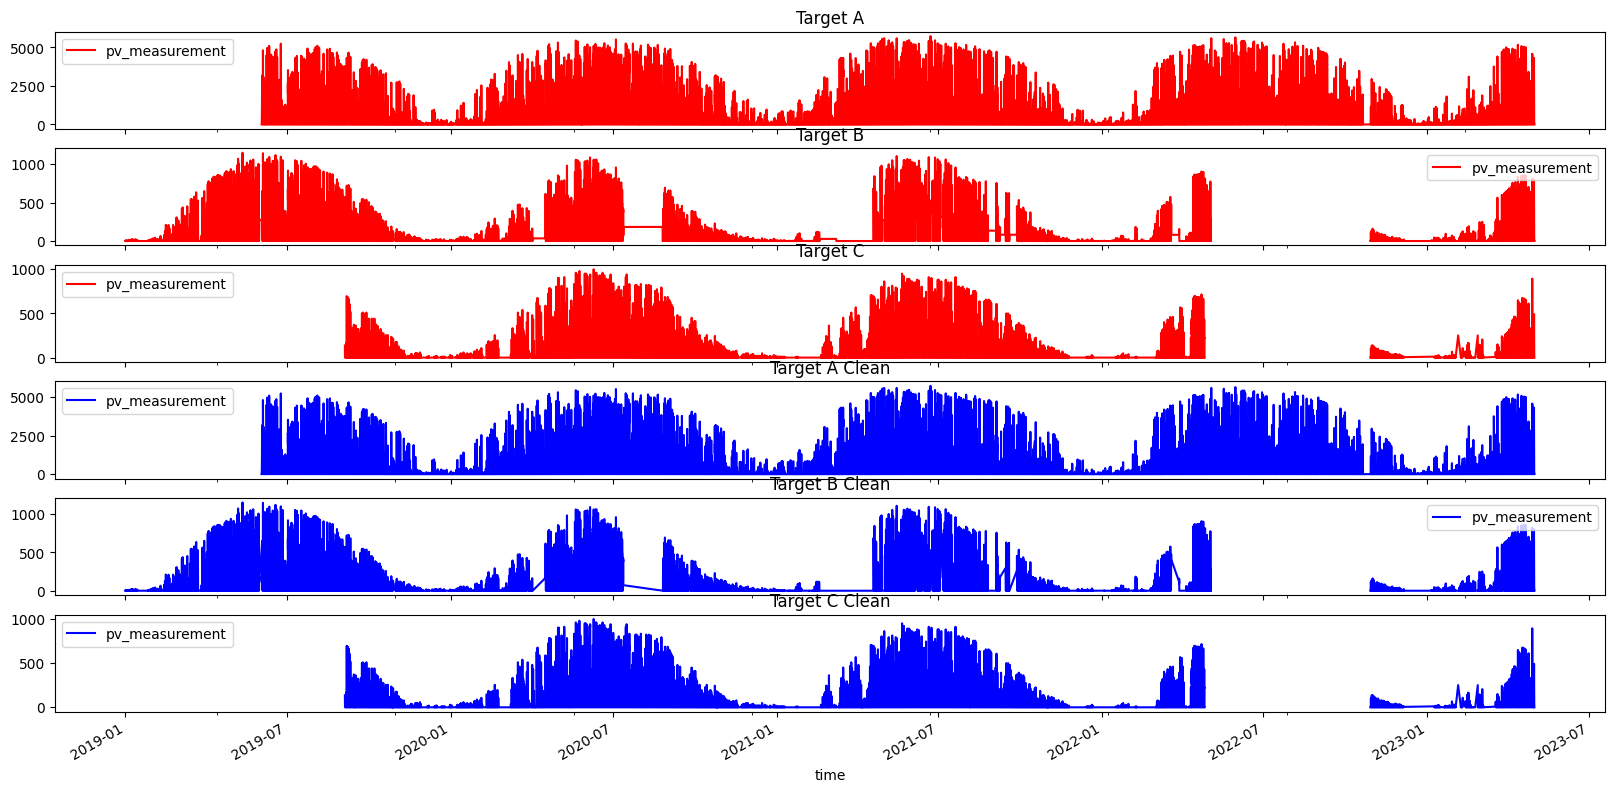

In [5]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



In [6]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])




In [7]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))



x,y:  29667 29667
x,y:  25996 25996
x,y:  23099 23099


In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))




x,y:  29667 29667
x,y:  25996 25996
x,y:  23099 23099


# Feature engineering

In [9]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat([train, test], ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


In [10]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,4986,3609,4342
cloud_base_agl:m,1612,1367,1686
snow_density:kgm3,28527,24141,21686


In [11]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [12]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)
    print(i)


0
1
2


In [13]:
X_frames_test[1]['dew_or_rime:idx_-1']


25996    0.0
25997    0.0
25998    0.0
25999    0.0
26000    0.0
        ... 
26711    0.0
26712    0.0
26713    0.0
26714    0.0
26715    0.0
Name: dew_or_rime:idx_-1, Length: 720, dtype: float64

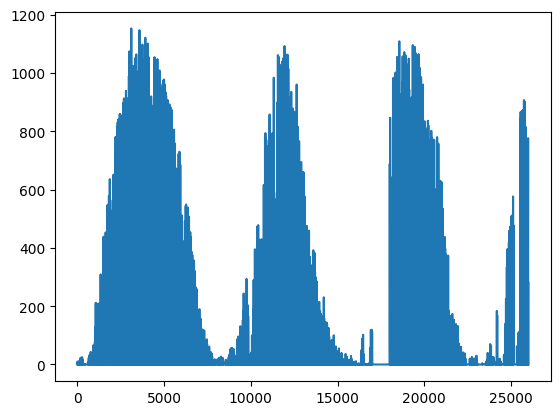

In [14]:

# Trengs å gjøre for å få h2 til å funke
def merge(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

x_train_a = merge(X_train[0], Y_train[0])
x_train_b = merge(X_train[1], Y_train[1])
x_train_c = merge(X_train[2], Y_train[2])

plt.plot(Y_train[1])



In [15]:



# Data set A, B and C to H2O

def data_to_h2o(x_train, y_train, x_test):
  
    x_train_h2o = h2o.H2OFrame(x_train)
    y_train = y_train.to_frame()
    y_train_h2o = h2o.H2OFrame(y_train)
    x_test_h2o = h2o.H2OFrame(x_test)
  
    return x_train_h2o, y_train_h2o, x_test_h2o



x_train_a_h2o, y_train_a_h2o, x_test_a_h2o = data_to_h2o(x_train_a, Y_train[0], X_frames_test[0])
x_train_b_h2o, y_train_b_h2o, x_test_b_h2o = data_to_h2o(x_train_b, Y_train[1], X_frames_test[1])
x_train_c_h2o, y_train_c_h2o, x_test_c_h2o = data_to_h2o(x_train_c, Y_train[2], X_frames_test[2])
y_train_a_h2o.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


pv_measurement
0
0
0
0
19.36
251.02
263.78
522.72
904.42
1238.82


# Training the model

In [16]:
print(y_train_a_h2o)
aml_a = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)
aml_b = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)
aml_c = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)

aml_a.train(x=x_train_a_h2o.columns, y=y_train_a_h2o.columns[0], training_frame=x_train_a_h2o)
aml_b.train(x=x_train_b_h2o.columns, y=y_train_b_h2o.columns[0], training_frame=x_train_b_h2o)
aml_c.train(x=x_train_c_h2o.columns, y=y_train_c_h2o.columns[0], training_frame=x_train_c_h2o)



  pv_measurement
            0
            0
            0
            0
           19.36
          251.02
          263.78
          522.72
          904.42
         1238.82
[29667 rows x 1 column]

AutoML progress: |
10:36:47.523: AutoML: XGBoost is not available; skipping it.
10:36:47.525: _train param, Dropping bad and constant columns: [snow_drift:idx]


10:36:48.151: _train param, Dropping bad and constant columns: [snow_drift:idx]

██████
10:37:05.564: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
10:37:47.110: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
10:38:01.179: _train param, Dropping bad and constant columns: [snow_drift:idx]

█
10:38:15.47: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
10:38:28.914: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
10:39:20.122: _train param, Dropping bad and constant columns: [snow_drift:idx]

█
10:39:30.704: _train param, Dropping bad and cons

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Evaluate training

In [17]:
lb = aml_a.leaderboard
lb.head(rows=lb.nrows) 



model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_23_20231031_103647,383.787,147292,179.827,nan,147292
StackedEnsemble_BestOfFamily_1_AutoML_23_20231031_103647,390.179,152240,184.005,nan,152240
GBM_3_AutoML_23_20231031_103647,390.205,152260,183.617,nan,152260
GBM_4_AutoML_23_20231031_103647,390.908,152809,182.005,nan,152809
GBM_2_AutoML_23_20231031_103647,397.042,157642,187.888,nan,157642
GBM_grid_1_AutoML_23_20231031_103647_model_1,398.779,159025,188.412,nan,159025
GBM_5_AutoML_23_20231031_103647,406.889,165559,193.474,nan,165559
GBM_1_AutoML_23_20231031_103647,412.362,170043,195.558,nan,170043
XRT_1_AutoML_23_20231031_103647,419.483,175966,196.46,0.778093,175966
DRF_1_AutoML_23_20231031_103647,422.413,178433,197.382,0.776863,178433


In [18]:
X_frames_test[0].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
is_day:idx,720.0,7.736111e-01,4.187846e-01,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
is_in_shadow:idx,720.0,2.236111e-01,4.169540e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
absolute_humidity_2m:gm3,720.0,8.205903e+00,2.178425e+00,3.200000,6.693750,8.050000e+00,9.981250e+00,1.367500e+01
air_density_2m:kgm3,720.0,1.233150e+00,3.210283e-02,1.151000,1.209000,1.238625e+00,1.260000e+00,1.299750e+00
ceiling_height_agl:m,720.0,7.510068e+03,7.849354e+03,53.299999,1219.593781,3.261587e+03,2.000000e+04,2.000000e+04
clear_sky_energy_1h:J,720.0,1.227651e+06,1.101479e+06,0.000000,48799.869141,9.337900e+05,2.276145e+06,2.987530e+06
clear_sky_rad:W,720.0,3.410140e+02,3.069119e+02,0.000000,17.950000,2.995750e+02,6.617375e+02,8.349500e+02
cloud_base_agl:m,720.0,3.652147e+03,5.736650e+03,30.225000,540.268738,1.213675e+03,3.138106e+03,2.000000e+04
dew_point_2m:K,720.0,2.808002e+02,4.339592e+00,268.100006,278.024994,2.810500e+02,2.843812e+02,2.895500e+02
diffuse_rad:W,720.0,8.490232e+01,7.859020e+01,0.000000,8.087500,7.530000e+01,1.342313e+02,3.075000e+02


# Make predictions

In [19]:
y_pred_a = aml_a.leader.predict(x_test_a_h2o)
y_pred_b = aml_b.leader.predict(x_test_b_h2o)
y_pred_c = aml_c.leader.predict(x_test_c_h2o)

y_pred_a = y_pred_a.as_data_frame()
y_pred_b = y_pred_b.as_data_frame()
y_pred_c = y_pred_c.as_data_frame()

y_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True)


stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


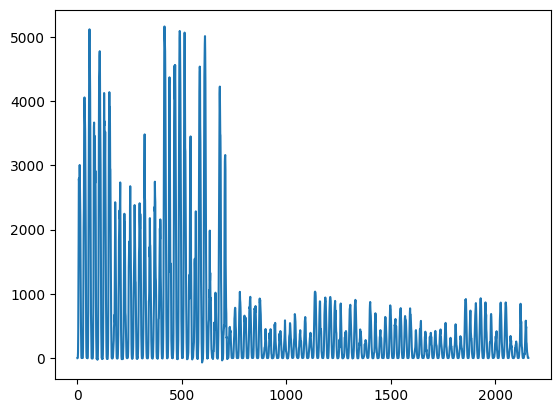

In [24]:
plt.plot(y_pred)


In [25]:
varimp = aml_a.varimp(use_pandas=True)
print(varimp)


                                    GBM_4  DeepLearning_1         GBM_1  \
direct_rad:W                 6.642250e-01        0.032903  4.475194e-01   
diffuse_rad:W                6.782457e-02        0.015444  6.354924e-02   
air_density_2m:kgm3          5.175227e-03        0.008588  3.871996e-03   
t_1000hPa:K                  6.672383e-03        0.016339  4.711570e-03   
ceiling_height_agl:m         5.172082e-03        0.015106  3.586145e-03   
wind_speed_u_10m:ms          8.153519e-03        0.016462  6.838531e-03   
total_cloud_cover:p          5.733204e-03        0.013779  6.362588e-03   
relative_humidity_1000hPa:p  5.163631e-03        0.012886  3.251203e-03   
wind_speed_w_1000hPa:ms      0.000000e+00        0.025278  0.000000e+00   
fresh_snow_3h:cm             8.694325e-05        0.021759  2.710151e-11   
is_day:idx                   9.195671e-04        0.017988  2.727547e-04   
sfc_pressure:hPa             2.641421e-03        0.013769  1.908593e-03   
rain_water:kgm2          

# Create submission

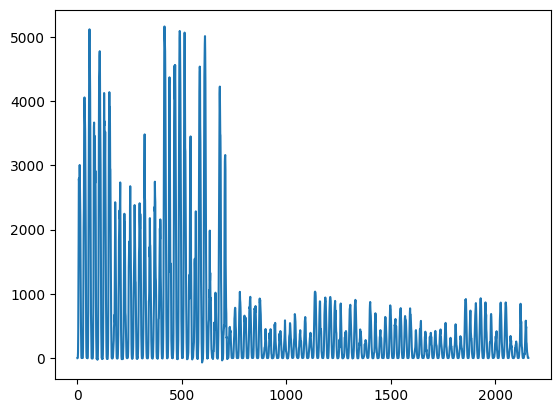

In [22]:
plt.plot(y_pred)


In [23]:
test = pd.read_csv('../data/test.csv')
test['prediction'] = y_pred['predict']
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_h2o.csv', index=False)
